In [16]:
def ard_rbf_kernel_efficient(x_a, x_b, alpha, rho, jitter):
    sqdist = jnp.sum(x_a ** 2, 1).reshape(-1, 1) + \
            jnp.sum(x_b ** 2, 1) - 2 * jnp.dot(x_a, x_b.T)
    return alpha ** 2 * jnp.exp(-0.5 / rho ** 2 * sqdist)

In [17]:
from functools import partial


In [18]:

from jax.config import config
from jax import grad
from jax import vmap
from jax import jit
from scipy.stats import norm as spnorm
from jax.scipy.stats import norm
import numpy as np
import jax.numpy as jnp
import os
os.environ['XLA_FLAGS'] = '--xla_cpu_enable_fast_math=false'


config.update("jax_enable_x64", True)


In [19]:
import numpy as np

In [20]:
np.random.seed(2)
x = np.random.uniform(-2, 2, size=100).reshape(-1, 1)


In [21]:
# lscale = np.reshape(np.random.uniform(1, 5), (1,))
lscale = 2
alpha = 1.

k_true = ard_rbf_kernel_efficient(x, x, alpha, lscale, jitter=0)


In [22]:
draw = np.random.multivariate_normal(np.zeros(x.shape[0]), k_true)


In [23]:
import matplotlib.pyplot as plt
%matplotlib inline


In [24]:
def func(X):
    return jnp.sin(X) #+ jnp.cos(3*X) + 1/(jnp.sin(2*X) + 2) + jnp.cos(5*X)


In [25]:
def generate_noisy_points(n=30, noise_variance=1e-6):
    np.random.seed(1000)
    X = np.random.uniform(-3., 3., (n, 1))
    y = func(X) + np.random.randn(n, 1) * noise_variance**0.5
    return X, y


In [26]:
MIN = -3

MAX = 3

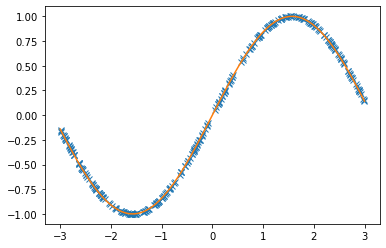

In [27]:
X_test, y_test = generate_noisy_points(300)
plt.plot(X_test, y_test, 'x')
plt.plot(jnp.linspace(MIN, MAX, 100), func(jnp.linspace(MIN, MAX, 100)))
plt.show()
X_test.sort(axis=0)


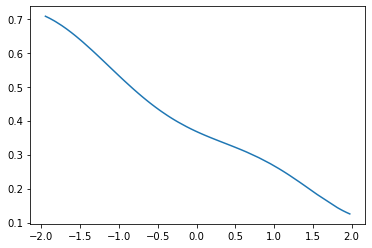

In [28]:
order = np.argsort(x[:, 0])

plt.plot(x[order], draw[order])


In [29]:
probs = spnorm.cdf(draw)


In [30]:
order

array([77, 81,  1, 55, 91, 67, 21, 57, 19, 51, 23, 27, 89, 24, 12, 38, 63,
       98, 14, 31,  6, 94, 28, 26, 56, 72,  9, 79, 64,  8, 90, 71,  5, 43,
       29, 86, 66, 52, 76, 73, 35, 83, 54, 85, 95,  4, 45, 22,  3,  0, 46,
       69, 30, 33, 17, 84, 41, 70, 34, 20, 13, 65, 11, 48, 50,  2, 87, 44,
       37, 80, 25, 61,  7, 10, 32, 96, 93, 97, 82, 39, 75, 92, 62, 47, 15,
       36, 78, 60, 74, 18, 53, 16, 99, 42, 49, 40, 59, 88, 68, 58])

In [31]:
y = np.random.binomial(1, probs)
y = func(x)


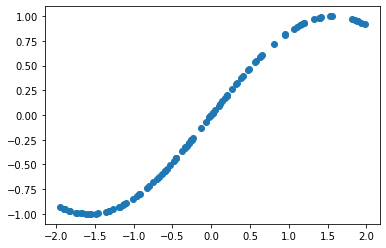

In [32]:
plt.scatter(x,y)

In [33]:
y = y.reshape((-1,))

In [34]:
y.shape

(100,)

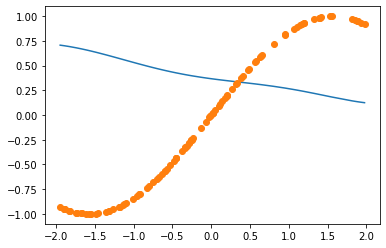

In [35]:
plt.plot(x[order], draw[order])
plt.plot(x[order], y[order], marker='o', linestyle='none')


In [36]:
n_inducing = 30

m = np.random.randn(n_inducing)
L = jnp.zeros((n_inducing, n_inducing))


In [37]:
indices = jnp.tril_indices(L.shape[0])
num_indices = indices[0].shape[0]


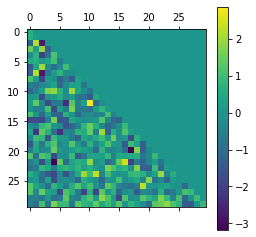

In [38]:
random_vals = np.random.randn(num_indices)
L = L.at[indices].set(random_vals)
plt.matshow(L)
plt.colorbar()


In [39]:
Z = np.random.uniform(-2, 2, 30).reshape(-1, 1)


In [40]:
from scipy.integrate import quad


def get_batch(x, y, batch_size):

    chosen = np.random.choice(x.shape[0], size=batch_size, replace=False)

    x_batch = x[chosen]
    y_batch = y[chosen]

    return x_batch, y_batch


def project_to_f(kmm, knm, knn, m, L):

    mean = knm @ jnp.linalg.solve(kmm, m)

    S = L @ L.T

    V1 = jnp.linalg.solve(kmm, S - kmm)
    V2 = jnp.linalg.solve(kmm, knm.T)

    cov = knn + knm @ V1 @ V2

    return mean, cov


def compute_qf_mean_cov(L, m, X, Z, cur_kern):

    knm = cur_kern(X, Z)
    kmm = cur_kern(Z, Z)
    knn = cur_kern(X, X)

    mean, cov = project_to_f(kmm, knm, knn, m, L)

    return mean, cov


In [41]:
@jit
def mvn_kl(mu_0, sigma_0, mu_1, sigma_1):

    logdet_sigma_1 = jnp.prod(jnp.array(jnp.linalg.slogdet(sigma_1)))
    logdet_sigma_0 = jnp.prod(jnp.array(jnp.linalg.slogdet(sigma_0)))
    term_1 = 0.5 * (logdet_sigma_1 - logdet_sigma_0)
    mu_outer = jnp.outer(mu_0 - mu_1, mu_0 - mu_1)
    inside_term = mu_outer + sigma_0 - sigma_1
    solved = jnp.linalg.solve(sigma_1, inside_term)
    term_2 = 0.5 * jnp.trace(solved)

    return term_1 + term_2


@jit
def mvn_kl_alt(mu_1, cov_1, mu_2, cov_2):

    _, logdet_1 = jnp.linalg.slogdet(cov_1)
    _, logdet_2 = jnp.linalg.slogdet(cov_2)
    logdet_term = logdet_2 - logdet_1
    solved = jnp.linalg.solve(cov_2, cov_1)
    tr_term = jnp.trace(solved)

    mean_term = (mu_2 - mu_1) @ (jnp.linalg.solve(cov_2, (mu_2 - mu_1)))

    return 0.5 * (logdet_term + tr_term + mean_term)


@jit
def normal_kl_1d(mu1, var1, mu2, var2):

    sd1 = jnp.sqrt(var1)
    sd2 = jnp.sqrt(var2)

    log_term = jnp.log(sd2) - jnp.log(sd1)
    main_term = (var1 + (mu1 - mu2) ** 2) / (2 * var2)

    return log_term + main_term

In [42]:
@jit
def log_y_f(y, f):
    
    # return y * norm.logcdf(f) + (1 - y) * norm.logcdf(-f)
    return y

In [52]:


def make_2d_quadrature_grid(x_quad, w_quad):

    grid = jnp.meshgrid(x_quad, x_quad)
    weights = jnp.outer(w_quad, w_quad).reshape(-1)
    stacked = jnp.stack([grid[0].reshape(-1), grid[1].reshape(-1)], axis=1)

    return stacked.T, weights


# TODO: Add config to specify number of quad points
x_quad, w_quad = np.polynomial.hermite.hermgauss(15)
x_quad, w_quad = jnp.array(x_quad), jnp.array(w_quad)

# TODO: Add config to specify number of quad points
x_quad_2d, w_quad_2d = np.polynomial.hermite.hermgauss(10)
x_quad_2d, w_quad_2d = jnp.array(x_quad_2d), jnp.array(w_quad_2d)
# x_quad_2d, w_quad_2d = make_2d_quadrature_grid(x_quad_2d, w_quad_2d)


@jit
def transform_x(x, sigma, mu):

    return jnp.sqrt(2) * sigma * x + mu


@partial(jit, static_argnums=0)
def expectation_1d(fun, means, vars):

    x_to_eval = transform_x(jnp.reshape(x_quad, (-1, 1)), jnp.sqrt(vars), means)

    multiplied = jnp.reshape(w_quad, (-1, 1)) * fun(x_to_eval)

    return jnp.sum(multiplied, axis=0) / jnp.sqrt(jnp.pi)


@partial(jit, static_argnums=3)
def expectation(ys, vars, means, log_y_f):
    # Returns the individual expectations for each of the ys.

    curried_lik = lambda f: log_y_f(ys, f)

    return expectation_1d(curried_lik, means, vars)


@partial(jit, static_argnums=2)
def expectation_2d(means, covs, fun, *args):
    """Calculates the expectation under a bivariate normal distribution with
    mean given by means and covariances given by covs.
    Args:
    means: Means of the bivariate normals; shape should be [N x 2].
    covs: Covariances of the bivariate normals; shape should be [N x 2 x 2].
    fun: The function whose expectation to compute under the bivariate
    normal. Should take in a matrix of shape [N x 2] and return a vector of
    shape [N,].
    args: Other args to fun. Each must be an array with initial shape [N,] to
    iterate over.
    
    Returns:
    A vector of N expectations, one for each of the inputs.
    """

    single_exp = lambda means, covs, *args: single_expectation_2d(
        means, covs, fun, *args
    )

    results = vmap(single_exp)(means, covs, *args)

    return results


@partial(jit, static_argnums=2)
def single_expectation_2d(mean, cov, fun, *args):

    cov_chol = jnp.linalg.cholesky(cov)

    scaled = (cov_chol * jnp.sqrt(2)) @ x_quad_2d + mean.reshape(-1, 1)

    return jnp.sum(fun(scaled.T, *args) * w_quad_2d) / jnp.pi

In [53]:
@partial(jit, static_argnums=0)
def expectation_1d(fun, means, vars):

    x_to_eval = transform_x(jnp.reshape(x_quad, (-1, 1)), jnp.sqrt(vars), means)

    multiplied = jnp.reshape(w_quad, (-1, 1)) * fun(x_to_eval)

    return jnp.sum(multiplied, axis=0) / jnp.sqrt(jnp.pi)

In [54]:


mvn_kl_jit = jit(mvn_kl)

alpha = 1.2
lscale = jnp.array([2.])


def compute_expected_log_lik(mean, cov, y_batch):

    return jnp.sum(expectation(y_batch, jnp.diag(cov), mean, log_y_f))


def compute_kl_term(m, L, Z, cur_kern):

    # For the log lik, we need q(u) and p(u).
    p_u_mean = jnp.zeros_like(m)
    p_u_cov = cur_kern(Z, Z)
    q_u_cov = L @ L.T
    q_u_mean = m

    kl = mvn_kl(q_u_mean, q_u_cov, p_u_mean, p_u_cov)

    return kl


In [55]:
ard_rbf_kernel_jit = jit(ard_rbf_kernel_efficient)


def compute_objective(x_batch, y_batch, m, L, Z, alpha, lscale):

    cur_kern = partial(
        ard_rbf_kernel_efficient, alpha=alpha, rho=lscale,
        jitter=1e-6)

    mean, cov = compute_qf_mean_cov(L, m, x_batch, Z, cur_kern)

    mu = mean
    sigma = jnp.diag(cov)
    expected_log_lik = compute_expected_log_lik(mu, cov, y_batch)

    kl_term = compute_kl_term(m, L, Z, cur_kern)
    cur_objective = expected_log_lik - kl_term

    return cur_objective


In [56]:
def extract_params(theta):

    # Get the parameters
    m = theta[:n_inducing]

    L = jnp.zeros((n_inducing, n_inducing))
    indices = jnp.tril_indices(L.shape[0])
    num_indices = indices[0].shape[0]

    L_elts = theta[n_inducing:n_inducing+num_indices]
    L = L.at[indices].set(L_elts)

    alpha, lscale = theta[-2:]**2
    lscale = jnp.reshape(lscale, (-1,))

    return m, L, alpha, lscale


def to_optimise(theta):

    x_batch, y_batch = get_batch(x, y, 3)

    m, L, alpha, lscale = extract_params(theta)

    cur_objective = - \
        compute_objective(x_batch, y_batch, m, L, Z, alpha, lscale)

    print(m)
    print(cur_objective)

    return cur_objective


In [57]:
def to_optimise_with_grad(theta):

    cur_val = to_optimise(theta)

    cur_grad = grad(to_optimise)(theta)

    return cur_val, cur_grad


In [58]:
start_vals = jnp.concatenate([
    np.random.randn(n_inducing),
    random_vals,
    jnp.reshape(alpha, (-1,)),
    jnp.reshape(lscale, (-1,))
])


In [59]:
from scipy.optimize import minimize

In [60]:
result = minimize(to_optimise_with_grad, start_vals, jac=True, tol=1e-1)


[-0.85918988  0.95469059  1.23123907  0.53757486 -0.03966394  1.38329195
 -0.4189089  -0.1378173   0.41477845  0.5308748  -0.31715028  0.37605003
  0.00934094  0.46185133 -0.24675019  1.25591741  2.77687874 -0.74095401
 -0.44870092  1.68968675  0.16172426 -0.55186583 -0.56929932  0.03496144
  1.00469368 -0.56890123  0.77581981  0.89126045  2.03054831 -0.02820501]
2.6904880954674284e+16
Traced<ConcreteArray([-0.85918988  0.95469059  1.23123907  0.53757486 -0.03966394  1.38329195
 -0.4189089  -0.1378173   0.41477845  0.5308748  -0.31715028  0.37605003
  0.00934094  0.46185133 -0.24675019  1.25591741  2.77687874 -0.74095401
 -0.44870092  1.68968675  0.16172426 -0.55186583 -0.56929932  0.03496144
  1.00469368 -0.56890123  0.77581981  0.89126045  2.03054831 -0.02820501], dtype=float64)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray([-0.85918988,  0.95469059,  1.23123907,  0.53757486,
             -0.03966394,  1.38329195, -0.4189089 , -0.1378173 ,
              0.41477845,  0.5308748

In [61]:
@jit
def transform_x(x, sigma, mu):

    return jnp.sqrt(2) * sigma * x + mu

In [62]:

@partial(jit, static_argnums=3)
def expectation(ys, vars, means, log_y_f):
    # Returns the individual expectations for each of the ys.

    curried_lik = lambda f: log_y_f(ys, f)

    return expectation_1d(curried_lik, means, vars)

In [63]:
m, L, alpha, lscale = extract_params(result.x)


In [64]:
lscale


array([1.60972118])

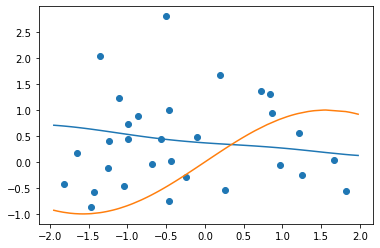

In [65]:
plt.scatter(Z[:, 0], m)
plt.plot(x[order], draw[order])
plt.plot(x[order], y[order])


In [66]:
m


array([-0.87598785,  0.93840376,  1.23178924,  0.5489511 , -0.03410476,
        1.36342694, -0.42124944, -0.11788675,  0.45000752,  0.47551221,
       -0.28862558,  0.39581085,  0.02558344,  0.45007284, -0.24553396,
        1.30229436,  2.80528017, -0.74711798, -0.4620518 ,  1.68125373,
        0.17538824, -0.58075144, -0.56789597,  0.03128145,  0.99109329,
       -0.53420962,  0.72708593,  0.88401608,  2.04795732, -0.05601665])

In [67]:
m_cov = L @ L.T
m_var = jnp.diag(m_cov)


In [68]:
o_m = jnp.argsort(Z[:, 0])


In [69]:
o_m

DeviceArray([ 6, 20,  0, 21, 28,  7, 11,  2, 18, 26,  8, 27,  4, 13, 16,
             24, 17, 12, 10,  9, 19, 25,  5, 15,  1, 29,  3, 14, 23, 22],            dtype=int64)

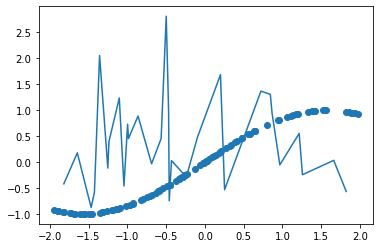

In [70]:
# plt.plot(x[order], draw[order])
plt.plot(Z[o_m, 0], m[np.array(o_m)])

plt.scatter(x,y)


In [1]:
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from jax import jit
import optax as ox
import jax.scipy as jsp
import gpjax as gpx
key = jr.PRNGKey(123)


AttributeError: module 'tensorflow.python.util.tf_inspect' has no attribute 'Parameter'

In [2]:
import distrax as dx


In [3]:
n = 5000
noise = 0.2

x = jr.uniform(key=key, minval=-5.0, maxval=5.0,
               shape=(n,)).sort().reshape(-1, 1)


def f(x): return jnp.sin(4 * x) + jnp.cos(2 * x)


signal = f(x)
y = signal + jr.normal(key, shape=signal.shape) * noise

D = gpx.Dataset(X=x, y=y)

xtest = jnp.linspace(-5.5, 5.5, 500).reshape(-1, 1)


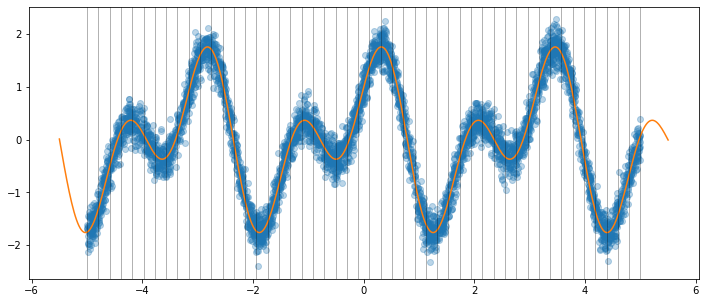

In [4]:
z = jnp.linspace(-5.0, 5.0, 50).reshape(-1, 1)

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(x, y, "o", alpha=0.3)
ax.plot(xtest, f(xtest))
[ax.axvline(x=z_i, color="black", alpha=0.3, linewidth=1) for z_i in z]
plt.show()


In [5]:
likelihood = gpx.Gaussian(num_datapoints=n)
prior = gpx.Prior(kernel=gpx.RBF())
p = prior * likelihood
q = gpx.VariationalGaussian(prior=prior, inducing_inputs=z)


In [6]:
svgp = gpx.StochasticVI(posterior=p, variational_family=q)


In [7]:
params, trainables, constrainers, unconstrainers = gpx.initialise(
    svgp, key).unpack()
params = gpx.transform(params, unconstrainers)

loss_fn = jit(svgp.elbo(D, constrainers, negative=True))


/tmp/ipykernel_2335560/2021119448.py:3: DeprecationWarning: `transform` will be deprecated in a future release. As of v0.5.0, please use `constrain` or `unconstrain` instead.
  params = gpx.transform(params, unconstrainers)


In [8]:
optimiser = ox.adam(learning_rate=0.01)

inference_state = gpx.fit_batches(
    objective=loss_fn,
    params=params,
    trainables=trainables,
    train_data=D,
    optax_optim=optimiser,
    n_iters=4000,
    key=jr.PRNGKey(42),
    batch_size=128
)
learned_params, training_history = inference_state.unpack()
learned_params = gpx.transform(learned_params, constrainers)


  0%|          | 0/4000 [00:00<?, ?it/s]

/tmp/ipykernel_2335560/4088580295.py:14: DeprecationWarning: `transform` will be deprecated in a future release. As of v0.5.0, please use `constrain` or `unconstrain` instead.
  learned_params = gpx.transform(learned_params, constrainers)


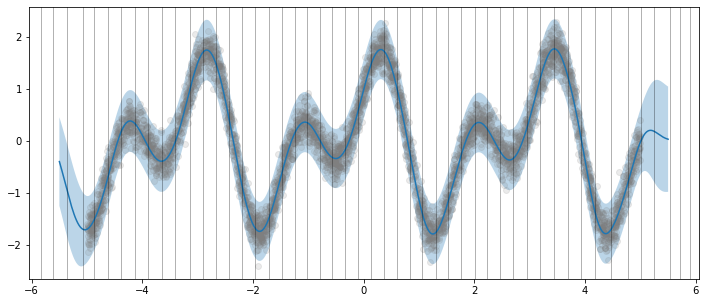

In [9]:
latent_dist = q(learned_params)(xtest)
predictive_dist = likelihood(latent_dist, learned_params)

meanf = predictive_dist.mean()
sigma = predictive_dist.stddev()

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(x, y, "o", alpha=0.15, label="Training Data", color="tab:gray")
ax.plot(xtest, meanf, label="Posterior mean", color="tab:blue")
ax.fill_between(xtest.flatten(), meanf - sigma, meanf + sigma, alpha=0.3)
[
    ax.axvline(x=z_i, color="black", alpha=0.3, linewidth=1)
    for z_i in learned_params["variational_family"]["inducing_inputs"]
]
plt.show()


In [10]:
from typing import *
from jax import vmap


In [14]:

# BATCH is tuple (X,y)
def variational_expectation(
    self, params: Dict, batch
):
    x, y = batch

    # q(f(x))
    predictive_dist = vmap(predict(params))(x[:, None])
    mean = predictive_dist.mean().val.reshape(-1, 1)
    variance = predictive_dist.variance().val.reshape(-1, 1)

    # log(p(y|f(x)))
    log_prob = vmap(
        lambda f, y: self.likelihood.link_function(
            f, params["likelihood"]
        ).log_prob(y)
    )

    # ≈ ∫[log(p(y|f(x))) q(f(x))] df(x)
    expectation = gauss_hermite_quadrature(log_prob, mean, variance, y=y)

    return expectation


In [ ]:
def predict(self, params: dict):
    """Compute the predictive distribution of the GP at the test inputs t.

        This is the integral q(f(t)) = ∫ p(f(t)|u) q(u) du, which can be computed in closed form as:

            N[f(t); μt + Ktz Kzz⁻¹ (μ - μz),  Ktt - Ktz Kzz⁻¹ Kzt + Ktz Kzz⁻¹ S Kzz⁻¹ Kzt ].

        Args:
            params (dict): The set of parameters that are to be used to parameterise our variational approximation and GP.

        Returns:
            Callable[[Array], dx.Distribution]: A function that accepts a set of test points and will return the predictive distribution at those points.
        """
    mu = params["variational_family"]["variational_mean"]
    sqrt = params["variational_family"]["variational_root_covariance"]
    z = params["variational_family"]["inducing_inputs"]
    m = self.num_inducing

    Kzz = gram(self.prior.kernel, z, params["kernel"])
    Kzz += I(m) * self.jitter
    Lz = jnp.linalg.cholesky(Kzz)
    μz = self.prior.mean_function(z, params["mean_function"])

    def predict_fn(test_inputs: Float[Array, "N D"]) -> dx.Distribution:
            t = test_inputs
            n_test = t.shape[0]
            Ktt = gram(self.prior.kernel, t, params["kernel"])
            Kzt = cross_covariance(self.prior.kernel, z, t, params["kernel"])
            μt = self.prior.mean_function(t, params["mean_function"])

            # Lz⁻¹ Kzt
            Lz_inv_Kzt = jsp.linalg.solve_triangular(Lz, Kzt, lower=True)

            # Kzz⁻¹ Kzt
            Kzz_inv_Kzt = jsp.linalg.solve_triangular(
                Lz.T, Lz_inv_Kzt, lower=False)

            # Ktz Kzz⁻¹ sqrt
            Ktz_Kzz_inv_sqrt = jnp.matmul(Kzz_inv_Kzt.T, sqrt)

            # μt + Ktz Kzz⁻¹ (μ - μz)
            mean = μt + jnp.matmul(Kzz_inv_Kzt.T, mu - μz)

            # Ktt  -  Ktz Kzz⁻¹ Kzt  +  Ktz Kzz⁻¹ S Kzz⁻¹ Kzt  [recall S = sqrt sqrtᵀ]
            covariance = (
                Ktt
                - jnp.matmul(Lz_inv_Kzt.T, Lz_inv_Kzt)
                + jnp.matmul(Ktz_Kzz_inv_sqrt, Ktz_Kzz_inv_sqrt.T)
            )
            covariance += I(n_test) * self.jitter

            return dx.MultivariateNormalFullCovariance(
                jnp.atleast_1d(mean.squeeze()), covariance
            )

    return predict_fn


In [22]:
def cross_covariance(
    kernel: Kernel, x: Float[Array, "N D"], y: Float[Array, "M D"], params: dict
) -> Float[Array, "N M"]:
    """For a given kernel, compute the :math:`m \times n` gram matrix on an a pair of input matrices with shape :math:`m \times d`  and :math:`n \times d` for :math:`d\geq 1`.

    Args:
        kernel (Kernel): The kernel for which the cross-covariance matrix should be computed for.
        x (Array): The first input matrix.
        y (Array): The second input matrix.
        params (dict): The kernel's parameter set.

    Returns:
        Array: The computed square Gram matrix.
    """
    return vmap(lambda x1: vmap(lambda y1: kernel(x1, y1, params))(y))(x)


NameError: name 'Kernel' is not defined